<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S15/blob/master/Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Final Assignment**

**This is to check which GPU is assigned**

In [6]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4701be73-f0dd-1b94-de1d-289394b1b209)


In [0]:
!pip install -U segmentation-models-pytorch

**Mount the gdrive**

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Import all required libraries**

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms,utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import notebook
import segmentation_models_pytorch as smp

In [0]:
import sys
folder = '/content/gdrive/My Drive'
sys.path.append(folder)

**Import all the modular codes created**

In [0]:
import UNetModel
import Albumentations
import MyClass
import SplitDataset
import TrainTest
import DisplayImages

**Extract all 5 data_partx.zip files (each containing 80k images) from gdrive to /content/data_x**


In [0]:
import zipfile
archive1 = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part1.zip')
archive1.extractall()
archive2 = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part2.zip')
archive2.extractall()
archive3 = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part3.zip')
archive3.extractall()
archive4 = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part4.zip')
archive4.extractall()
archive5 = zipfile.ZipFile(f'/content/gdrive/My Drive/Mask_Rcnn/Dataset/data_part5.zip')
archive5.extractall()

**Make Background directory in /content to store 100 bg images from gdrive to colab**

In [12]:
data_root ='/content/gdrive/My Drive/Mask_Rcnn'

%mkdir Background

import copy
for i in range(1,101):
   bg = Image.open(f'{data_root}/Background/bg{str(i)}.jpg')
   bg.save(f"/content/Background/bg{str(i)}.jpg")

!ls Background | wc -l

100


**Store paths of each folder**

In [0]:
import glob
bg = sorted(glob.glob('/content/Background/*',recursive=True)) 
fg_bg = sorted(glob.glob('/content/data_1/Fg-Bg/*',recursive=True))+sorted(glob.glob('/content/data_2/Fg-Bg/*',recursive=True))+sorted(glob.glob('/content/data_3/Fg-Bg/*',recursive=True))+sorted(glob.glob('/content/data_4/Fg-Bg/*',recursive=True))+sorted(glob.glob('/content/data_5/Fg-Bg/*',recursive=True)) 
fg_bg_mask = sorted(glob.glob('/content/data_1/Fg-Bg-Mask/*',recursive=True))+sorted(glob.glob('/content/data_2/Fg-Bg-Mask/*',recursive=True))+sorted(glob.glob('/content/data_3/Fg-Bg-Mask/*',recursive=True))+sorted(glob.glob('/content/data_4/Fg-Bg-Mask/*',recursive=True))+sorted(glob.glob('/content/data_5/Fg-Bg-Mask/*',recursive=True)) 
depth = sorted(glob.glob('/content/data_1/Depth/*',recursive=True))+sorted(glob.glob('/content/data_2/Depth/*',recursive=True))+sorted(glob.glob('/content/data_3/Depth/*',recursive=True))+sorted(glob.glob('/content/data_4/Depth/*',recursive=True))+sorted(glob.glob('/content/data_5/Depth/*',recursive=True)) 

**Call albumentation transforms and the custom dataset class**

In [0]:
album_transform = Albumentations.AlbumentationTransforms() 
train_dataset = MyClass.CustomDataset(album_transform, bg, fg_bg, fg_bg_mask, depth)

**Split the dataset into 70:30 for train:test**

In [15]:
train_set,val_set = SplitDataset.split(train_dataset,train_split=70)

Total dataset =  400000
Train set =  280000
Test set =  120000


**Printing the number of items in each dataset**

In [16]:
print("No. of background images = ",len(train_dataset.bg))
print("No. of foreground-background images = ",len(train_dataset.fg_bg))
print("No. of foreground-background-mask images = ",len(train_dataset.fg_bg_mask))
print("No. of depth images = ",len(train_dataset.depth))

No. of background images =  100
No. of foreground-background images =  400000
No. of foreground-background-mask images =  400000
No. of depth images =  400000


**Load data for train and test using DataLoader**

In [0]:
train_dataloader = DataLoader(train_set, batch_size=16, pin_memory=True)

test_dataloader = DataLoader(val_set, batch_size=16, pin_memory=True)


**Display images**

Train set


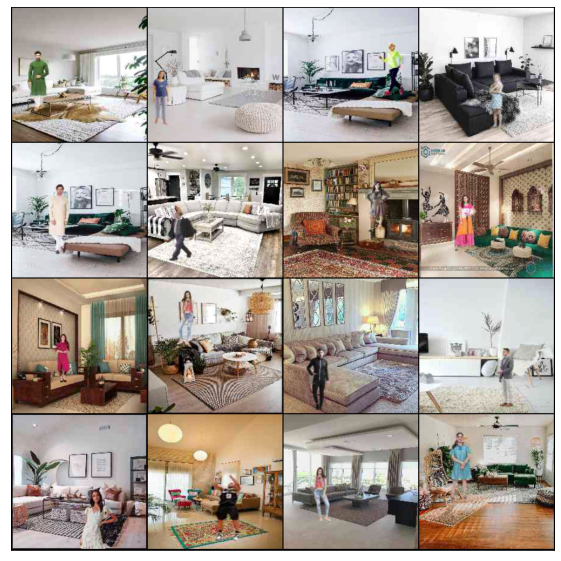

Val set


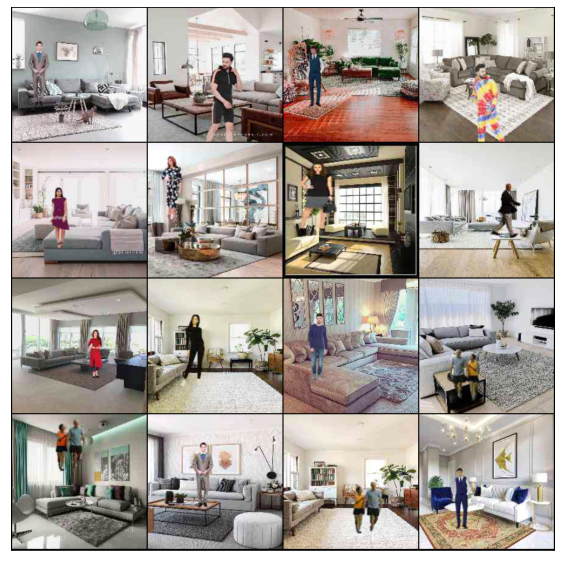

In [18]:
train_images = next(iter(train_dataloader))
test_images = next(iter(test_dataloader))
imgs = train_images["fg_bg"]
imgs1 = test_images["fg_bg"]
print("Train set")
DisplayImages.display_images(imgs[::1],nrow=4)
print("Val set")
DisplayImages.display_images(imgs1[::1],nrow=4)

**Model Summary**

In [52]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNetModel.UNet(6,1).to(device)

#Freeze the layers
count = 0
for child in model.children():
    count += 1
    if count < 4 or count > 10:
      for param in child.parameters():
          param.requires_grad = False

#print(model)
summary(model, input_size=[(3,64,64),(3,64,64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,520
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
        DoubleConv-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
      BatchNorm2d-13          [-1, 128, 32, 32]             256
             ReLU-14          [-1, 128,

**Save weights in colab for each epoch**

In [0]:
from pathlib import Path
PATH= Path('/content/saved_models')
PATH.mkdir(exist_ok= True)

**Train()**

In [0]:
def train( model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, data in enumerate(train_loader):

      data["bg"] = data["bg"].to(device)
      data["fg_bg"] = data["fg_bg"].to(device)
      data["fg_bg_mask"] = data["fg_bg_mask"].to(device)
      data["depth"] = data["depth"].to(device)

      optimizer.zero_grad()
      output=model(data["bg"], data["fg_bg"])
      loss= criterion(output,data["fg_bg_mask"])
      loss.backward()
      optimizer.step()
      if batch_idx % 50 == 0:
        print('Train Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,batch_idx*len(data),len(train_loader.dataset), 
                                                             100.*batch_idx/len(train_loader), loss.item()))
    
      if batch_idx % 5000 == 0:
        print("Ground Truth")
        DisplayImages.display_images(data["fg_bg_mask"][::1].cpu(),nrow=4)
        print("Training")
        display_images(output[::1],nrow=4)

      if batch_idx % 2000 == 0:
        torch.save(model.state_dict(), PATH/f"{batch_idx}.pth")

**Test()**

In [0]:
def test( model, criterion, device, test_loader, metric):
  model.eval()
  test_loss=0
  correct=0
  metric_avg=0
  with torch.no_grad():
    for data in test_loader:
      data["bg"] = data["bg"].to(device)
      data["fg_bg"] = data["fg_bg"].to(device)
      data["fg_bg_mask"] = data["fg_bg_mask"].to(device)
      data["depth"] = data["depth"].to(device)
      output=model(data["bg"], data["fg_bg"])

      test_loss+=criterion(output,data["fg_bg_mask"]).item() 
      pred=output.argmax(dim=1,keepdim=True)
      correct+=pred.eq(output.view_as(pred)).sum().item()
      metric_value = metric(output, data['depth']).cpu().detach().numpy()
      metric_avg+=metric_value
      if count==10:
        break
    metric_avg = metric_avg/len(test_loader)
    
    print("Average Metric = ", metric_avg)
    print("Ground Truth")
    DisplayImages.display_images(data["depth"][::1].cpu(),nrow=4)
    print("Testing")
    DisplayImages.display_images(output[::1],nrow=4)
    test_loss/=len(test_loader.dataset)

**Hyperparameters**

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR

optim = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.9,weight_decay = 0.0001) 
#criterion = nn.L1Loss()
criterion = nn.BCEWithLogitsLoss()
scheduler = OneCycleLR(optim, max_lr = 0.02, total_steps=None, epochs=30, steps_per_epoch=len(train_dataloader), pct_start=1/3, anneal_strategy='linear', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =10)

**Epochs**

Train Epoch : 1 [0/280000 (0%)]	Loss: 0.768991
Ground Truth


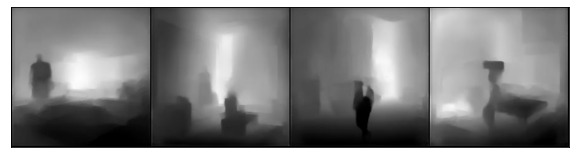

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


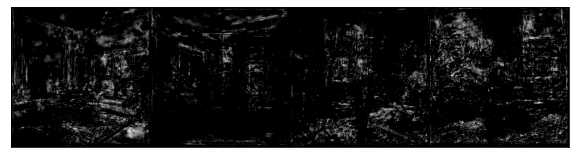

Train Epoch : 1 [200/280000 (1%)]	Loss: 0.181271
Train Epoch : 1 [400/280000 (1%)]	Loss: 0.146398
Train Epoch : 1 [600/280000 (2%)]	Loss: 0.145066
Train Epoch : 1 [800/280000 (2%)]	Loss: 0.134126
Train Epoch : 1 [1000/280000 (3%)]	Loss: 0.130587
Train Epoch : 1 [1200/280000 (3%)]	Loss: 0.120457
Train Epoch : 1 [1400/280000 (4%)]	Loss: 0.110582
Train Epoch : 1 [1600/280000 (5%)]	Loss: 0.115437
Train Epoch : 1 [1800/280000 (5%)]	Loss: 0.110000
Train Epoch : 1 [2000/280000 (6%)]	Loss: 0.097499
Train Epoch : 1 [2200/280000 (6%)]	Loss: 0.106055
Train Epoch : 1 [2400/280000 (7%)]	Loss: 0.088859
Train Epoch : 1 [2600/280000 (7%)]	Loss: 0.094803
Train Epoch : 1 [2800/280000 (8%)]	Loss: 0.087482
Train Epoch : 1 [3000/280000 (9%)]	Loss: 0.090721
Train Epoch : 1 [3200/280000 (9%)]	Loss: 0.078622
Train Epoch : 1 [3400/280000 (10%)]	Loss: 0.087201
Train Epoch : 1 [3600/280000 (10%)]	Loss: 0.089614
Train Epoch : 1 [3800/280000 (11%)]	Loss: 0.071158
Train Epoch : 1 [4000/280000 (11%)]	Loss: 0.077264


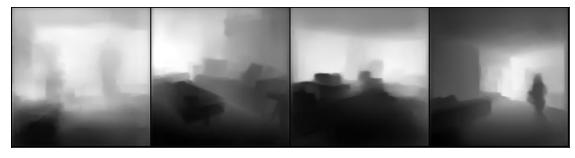

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


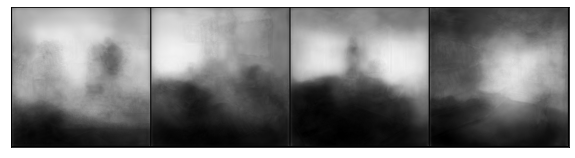

Train Epoch : 1 [20200/280000 (58%)]	Loss: 0.062178
Train Epoch : 1 [20400/280000 (58%)]	Loss: 0.060014
Train Epoch : 1 [20600/280000 (59%)]	Loss: 0.059743
Train Epoch : 1 [20800/280000 (59%)]	Loss: 0.064812
Train Epoch : 1 [21000/280000 (60%)]	Loss: 0.058716
Train Epoch : 1 [21200/280000 (61%)]	Loss: 0.059933
Train Epoch : 1 [21400/280000 (61%)]	Loss: 0.068191
Train Epoch : 1 [21600/280000 (62%)]	Loss: 0.064174
Train Epoch : 1 [21800/280000 (62%)]	Loss: 0.058570
Train Epoch : 1 [22000/280000 (63%)]	Loss: 0.056127
Train Epoch : 1 [22200/280000 (63%)]	Loss: 0.068554
Train Epoch : 1 [22400/280000 (64%)]	Loss: 0.062110
Train Epoch : 1 [22600/280000 (65%)]	Loss: 0.065982
Train Epoch : 1 [22800/280000 (65%)]	Loss: 0.064152
Train Epoch : 1 [23000/280000 (66%)]	Loss: 0.061769
Train Epoch : 1 [23200/280000 (66%)]	Loss: 0.068050
Train Epoch : 1 [23400/280000 (67%)]	Loss: 0.060117
Train Epoch : 1 [23600/280000 (67%)]	Loss: 0.063916
Train Epoch : 1 [23800/280000 (68%)]	Loss: 0.064315
Train Epoch 

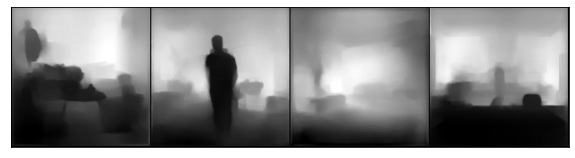

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


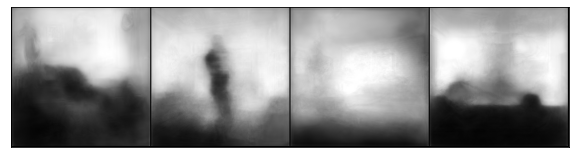

In [0]:
#Depth epoch1
for epoch in range(1,2):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()

Train Epoch : 2 [0/280000 (0%)]	Loss: 0.062364
Ground Truth


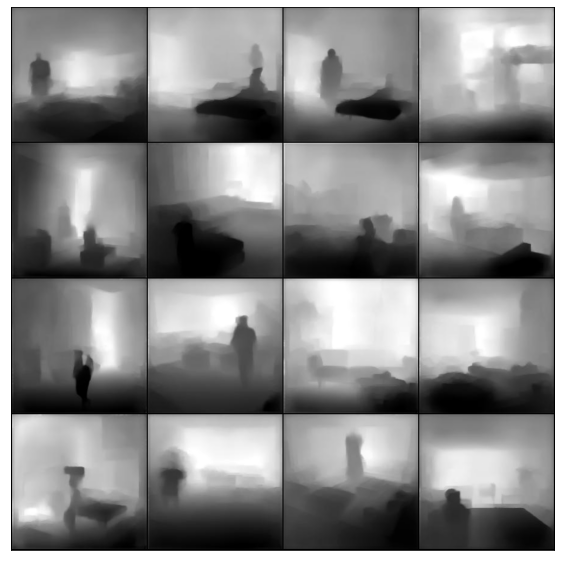

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


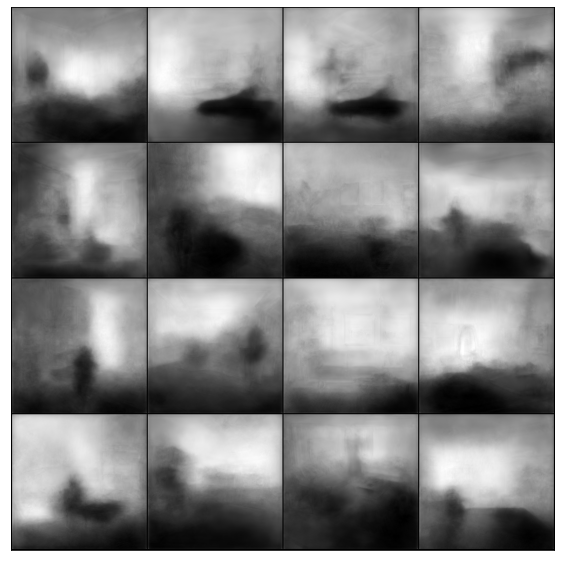

Train Epoch : 2 [200/280000 (1%)]	Loss: 0.050631
Train Epoch : 2 [400/280000 (1%)]	Loss: 0.059310
Train Epoch : 2 [600/280000 (2%)]	Loss: 0.051506
Train Epoch : 2 [800/280000 (2%)]	Loss: 0.058872
Train Epoch : 2 [1000/280000 (3%)]	Loss: 0.062212
Train Epoch : 2 [1200/280000 (3%)]	Loss: 0.060149
Train Epoch : 2 [1400/280000 (4%)]	Loss: 0.057967
Train Epoch : 2 [1600/280000 (5%)]	Loss: 0.059757
Train Epoch : 2 [1800/280000 (5%)]	Loss: 0.067334
Train Epoch : 2 [2000/280000 (6%)]	Loss: 0.058480
Train Epoch : 2 [2200/280000 (6%)]	Loss: 0.059802
Train Epoch : 2 [2400/280000 (7%)]	Loss: 0.051230
Train Epoch : 2 [2600/280000 (7%)]	Loss: 0.054334
Train Epoch : 2 [2800/280000 (8%)]	Loss: 0.049143
Train Epoch : 2 [3000/280000 (9%)]	Loss: 0.057503
Train Epoch : 2 [3200/280000 (9%)]	Loss: 0.047706
Train Epoch : 2 [3400/280000 (10%)]	Loss: 0.058383
Train Epoch : 2 [3600/280000 (10%)]	Loss: 0.060980
Train Epoch : 2 [3800/280000 (11%)]	Loss: 0.051389
Train Epoch : 2 [4000/280000 (11%)]	Loss: 0.051544


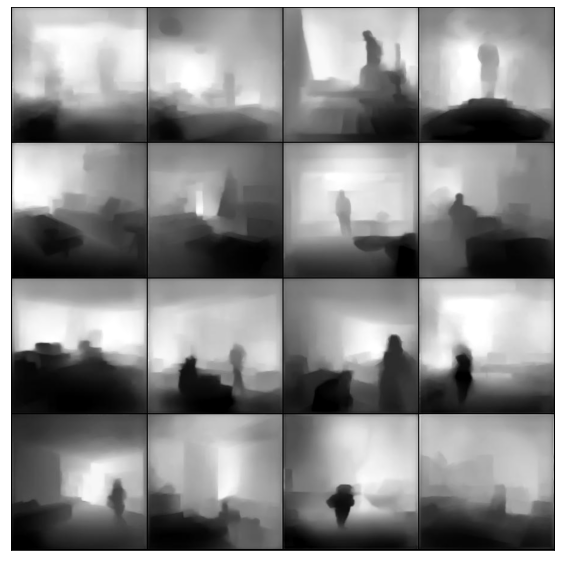

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


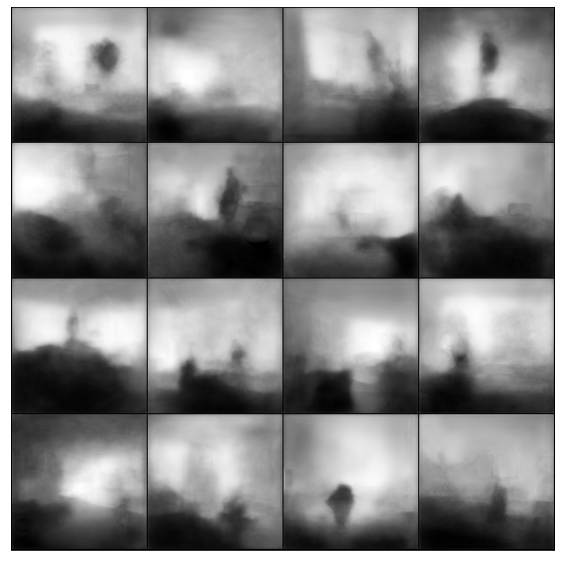

Train Epoch : 2 [20200/280000 (58%)]	Loss: 0.052414
Train Epoch : 2 [20400/280000 (58%)]	Loss: 0.055411
Train Epoch : 2 [20600/280000 (59%)]	Loss: 0.055201
Train Epoch : 2 [20800/280000 (59%)]	Loss: 0.056073
Train Epoch : 2 [21000/280000 (60%)]	Loss: 0.049927
Train Epoch : 2 [21200/280000 (61%)]	Loss: 0.053679
Train Epoch : 2 [21400/280000 (61%)]	Loss: 0.060225
Train Epoch : 2 [21600/280000 (62%)]	Loss: 0.053962
Train Epoch : 2 [21800/280000 (62%)]	Loss: 0.050626
Train Epoch : 2 [22000/280000 (63%)]	Loss: 0.051075
Train Epoch : 2 [22200/280000 (63%)]	Loss: 0.060279
Train Epoch : 2 [22400/280000 (64%)]	Loss: 0.053730
Train Epoch : 2 [22600/280000 (65%)]	Loss: 0.056046
Train Epoch : 2 [22800/280000 (65%)]	Loss: 0.052931
Train Epoch : 2 [23000/280000 (66%)]	Loss: 0.050803
Train Epoch : 2 [23200/280000 (66%)]	Loss: 0.061845
Train Epoch : 2 [23400/280000 (67%)]	Loss: 0.050440
Train Epoch : 2 [23600/280000 (67%)]	Loss: 0.056905
Train Epoch : 2 [23800/280000 (68%)]	Loss: 0.061892
Train Epoch 

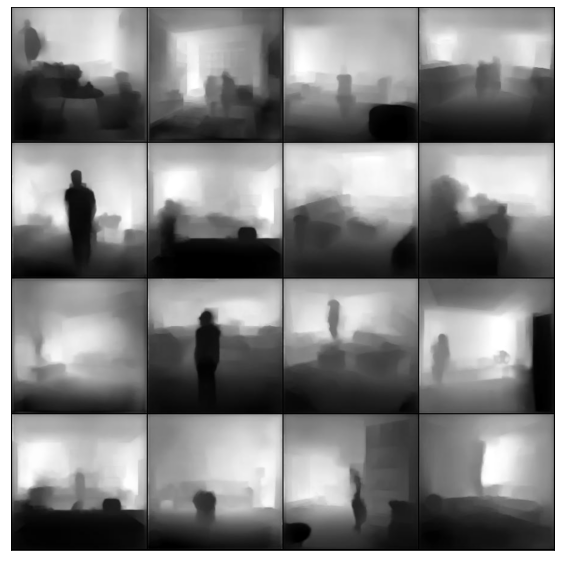

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


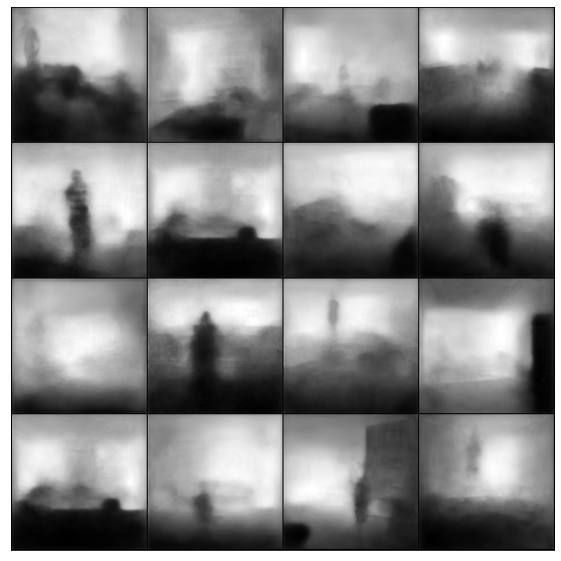

In [0]:
#Depth epoch2
for epoch in range(2,3):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()
  torch.save(model.state_dict(), '/content/gdrive/My Drive/model_2.pth')

Train Epoch : 3 [0/280000 (0%)]	Loss: 0.054120
Ground Truth


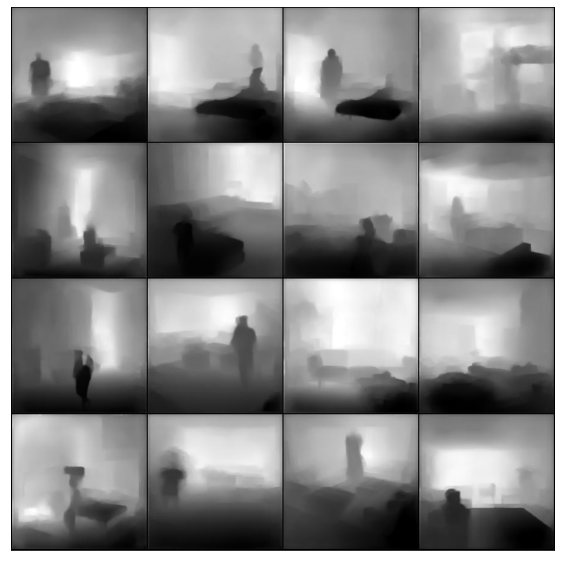

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


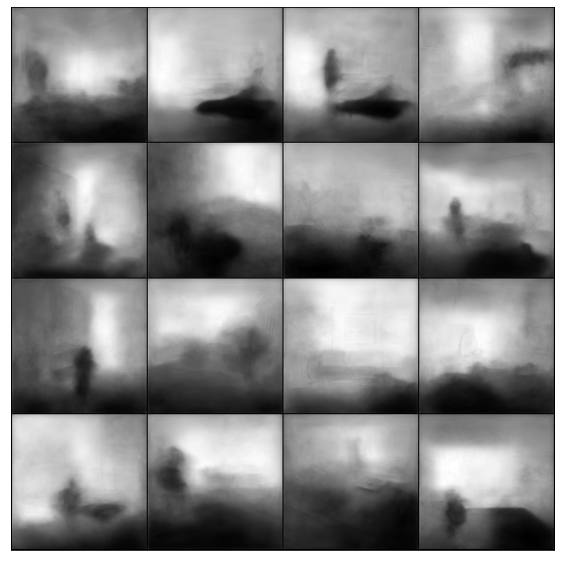

Train Epoch : 3 [200/280000 (1%)]	Loss: 0.048383
Train Epoch : 3 [400/280000 (1%)]	Loss: 0.059381
Train Epoch : 3 [600/280000 (2%)]	Loss: 0.049194
Train Epoch : 3 [800/280000 (2%)]	Loss: 0.050548
Train Epoch : 3 [1000/280000 (3%)]	Loss: 0.058050
Train Epoch : 3 [1200/280000 (3%)]	Loss: 0.057705
Train Epoch : 3 [1400/280000 (4%)]	Loss: 0.053063
Train Epoch : 3 [1600/280000 (5%)]	Loss: 0.058603
Train Epoch : 3 [1800/280000 (5%)]	Loss: 0.062154
Train Epoch : 3 [2000/280000 (6%)]	Loss: 0.050858
Train Epoch : 3 [2200/280000 (6%)]	Loss: 0.054901
Train Epoch : 3 [2400/280000 (7%)]	Loss: 0.044718
Train Epoch : 3 [2600/280000 (7%)]	Loss: 0.049951
Train Epoch : 3 [2800/280000 (8%)]	Loss: 0.045940
Train Epoch : 3 [3000/280000 (9%)]	Loss: 0.050769
Train Epoch : 3 [3200/280000 (9%)]	Loss: 0.044318
Train Epoch : 3 [3400/280000 (10%)]	Loss: 0.053643
Train Epoch : 3 [3600/280000 (10%)]	Loss: 0.057052
Train Epoch : 3 [3800/280000 (11%)]	Loss: 0.043306
Train Epoch : 3 [4000/280000 (11%)]	Loss: 0.050979


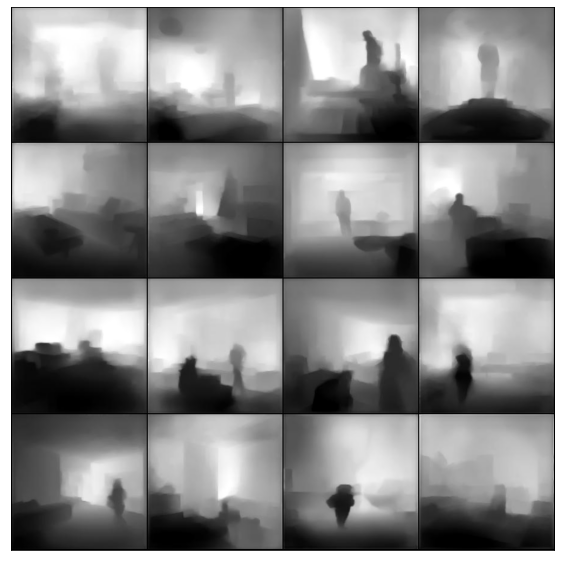

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


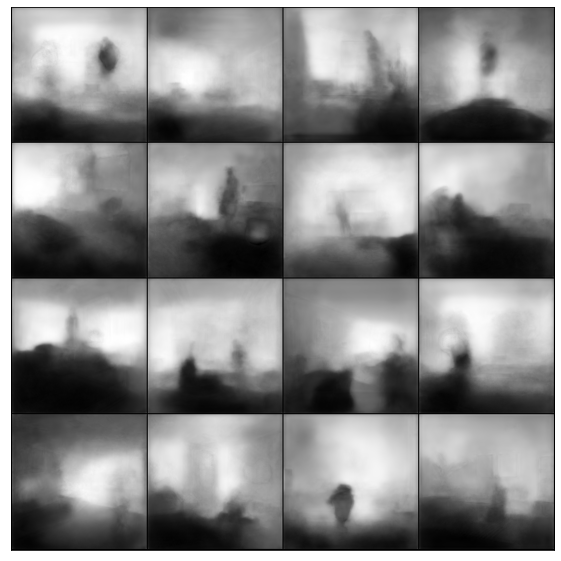

Train Epoch : 3 [20200/280000 (58%)]	Loss: 0.051599
Train Epoch : 3 [20400/280000 (58%)]	Loss: 0.051934
Train Epoch : 3 [20600/280000 (59%)]	Loss: 0.054228
Train Epoch : 3 [20800/280000 (59%)]	Loss: 0.054759
Train Epoch : 3 [21000/280000 (60%)]	Loss: 0.050327
Train Epoch : 3 [21200/280000 (61%)]	Loss: 0.048264
Train Epoch : 3 [21400/280000 (61%)]	Loss: 0.060229
Train Epoch : 3 [21600/280000 (62%)]	Loss: 0.053572
Train Epoch : 3 [21800/280000 (62%)]	Loss: 0.047120
Train Epoch : 3 [22000/280000 (63%)]	Loss: 0.046535
Train Epoch : 3 [22200/280000 (63%)]	Loss: 0.060713
Train Epoch : 3 [22400/280000 (64%)]	Loss: 0.055919
Train Epoch : 3 [22600/280000 (65%)]	Loss: 0.053443
Train Epoch : 3 [22800/280000 (65%)]	Loss: 0.052998
Train Epoch : 3 [23000/280000 (66%)]	Loss: 0.047877
Train Epoch : 3 [23200/280000 (66%)]	Loss: 0.058450
Train Epoch : 3 [23400/280000 (67%)]	Loss: 0.050437
Train Epoch : 3 [23600/280000 (67%)]	Loss: 0.051658
Train Epoch : 3 [23800/280000 (68%)]	Loss: 0.058746
Train Epoch 

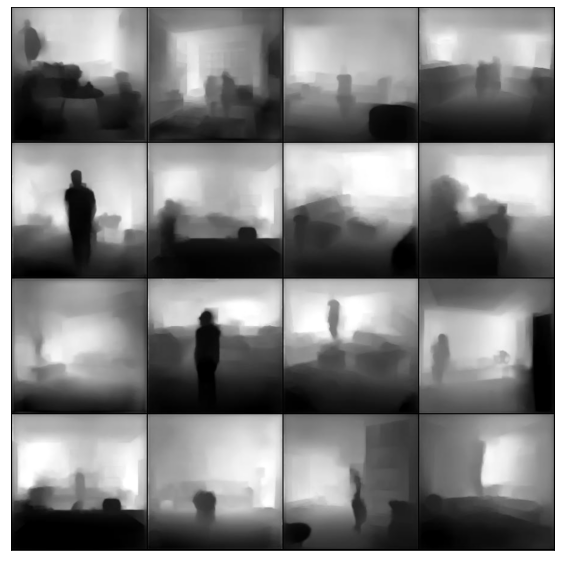

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


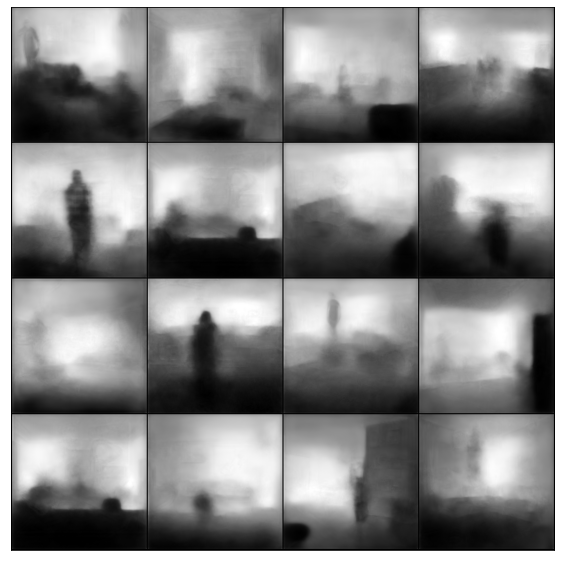

In [0]:
#Depth epoch3
for epoch in range(3,4):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()
  torch.save(model.state_dict(), '/content/gdrive/My Drive/model_3.pth')

Train Epoch : 4 [0/280000 (0%)]	Loss: 0.058365
Ground Truth


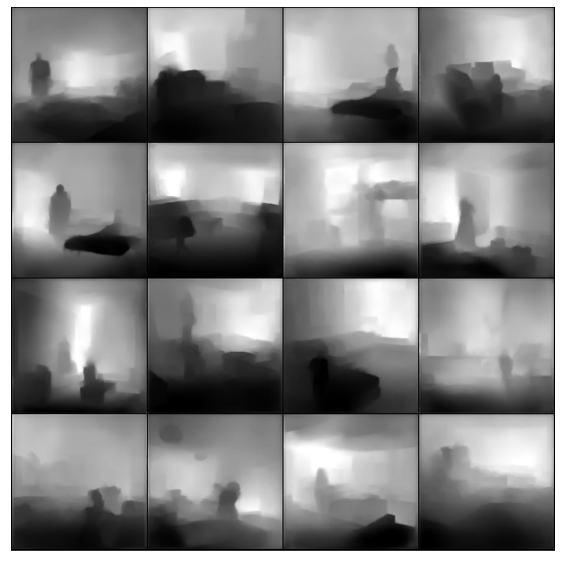

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


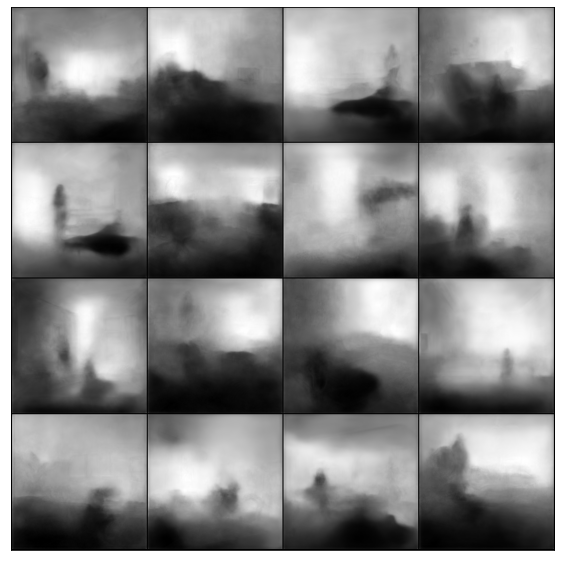

Train Epoch : 4 [200/280000 (0%)]	Loss: 0.059869
Train Epoch : 4 [400/280000 (1%)]	Loss: 0.049758
Train Epoch : 4 [600/280000 (1%)]	Loss: 0.065892
Train Epoch : 4 [800/280000 (1%)]	Loss: 0.061994
Train Epoch : 4 [1000/280000 (1%)]	Loss: 0.050957
Train Epoch : 4 [1200/280000 (2%)]	Loss: 0.052156
Train Epoch : 4 [1400/280000 (2%)]	Loss: 0.052632
Train Epoch : 4 [1600/280000 (2%)]	Loss: 0.054985
Train Epoch : 4 [1800/280000 (3%)]	Loss: 0.052572
Train Epoch : 4 [2000/280000 (3%)]	Loss: 0.057943
Train Epoch : 4 [2200/280000 (3%)]	Loss: 0.051937
Train Epoch : 4 [2400/280000 (3%)]	Loss: 0.065084
Train Epoch : 4 [2600/280000 (4%)]	Loss: 0.046590
Train Epoch : 4 [2800/280000 (4%)]	Loss: 0.060451
Train Epoch : 4 [3000/280000 (4%)]	Loss: 0.044237
Train Epoch : 4 [3200/280000 (5%)]	Loss: 0.049853
Train Epoch : 4 [3400/280000 (5%)]	Loss: 0.062820
Train Epoch : 4 [3600/280000 (5%)]	Loss: 0.058947
Train Epoch : 4 [3800/280000 (5%)]	Loss: 0.074546
Train Epoch : 4 [4000/280000 (6%)]	Loss: 0.046691
Trai

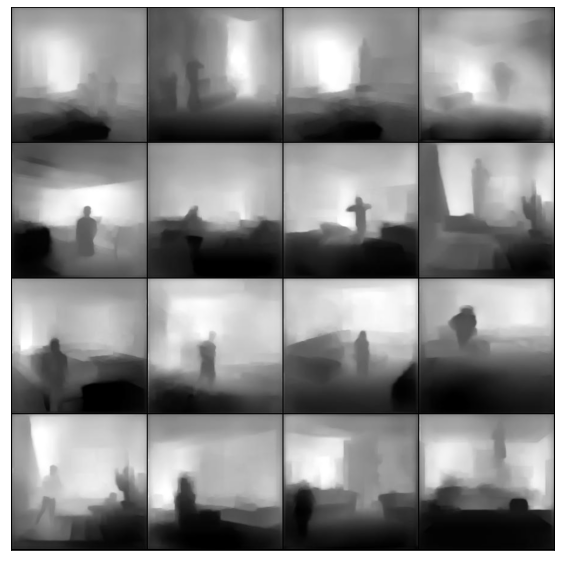

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


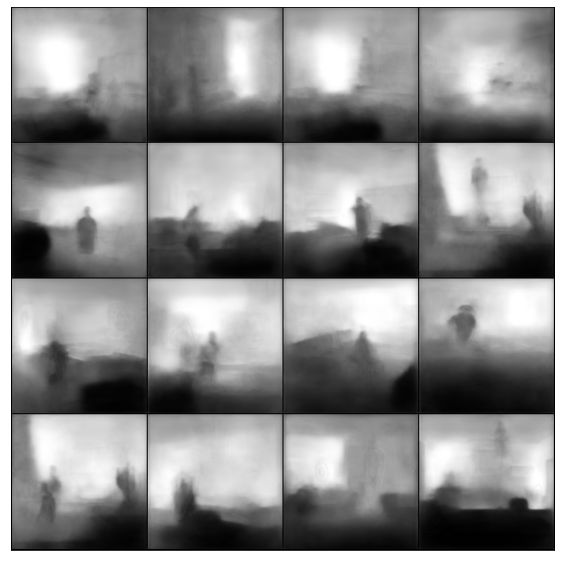

Train Epoch : 4 [20200/280000 (29%)]	Loss: 0.049097
Train Epoch : 4 [20400/280000 (29%)]	Loss: 0.052870
Train Epoch : 4 [20600/280000 (29%)]	Loss: 0.052430
Train Epoch : 4 [20800/280000 (30%)]	Loss: 0.052594
Train Epoch : 4 [21000/280000 (30%)]	Loss: 0.060333
Train Epoch : 4 [21200/280000 (30%)]	Loss: 0.048378
Train Epoch : 4 [21400/280000 (31%)]	Loss: 0.055044
Train Epoch : 4 [21600/280000 (31%)]	Loss: 0.047541
Train Epoch : 4 [21800/280000 (31%)]	Loss: 0.048029
Train Epoch : 4 [22000/280000 (31%)]	Loss: 0.049831
Train Epoch : 4 [22200/280000 (32%)]	Loss: 0.058418
Train Epoch : 4 [22400/280000 (32%)]	Loss: 0.044217
Train Epoch : 4 [22600/280000 (32%)]	Loss: 0.051677
Train Epoch : 4 [22800/280000 (33%)]	Loss: 0.047408
Train Epoch : 4 [23000/280000 (33%)]	Loss: 0.050264
Train Epoch : 4 [23200/280000 (33%)]	Loss: 0.046783
Train Epoch : 4 [23400/280000 (33%)]	Loss: 0.051951
Train Epoch : 4 [23600/280000 (34%)]	Loss: 0.050704
Train Epoch : 4 [23800/280000 (34%)]	Loss: 0.048631
Train Epoch 

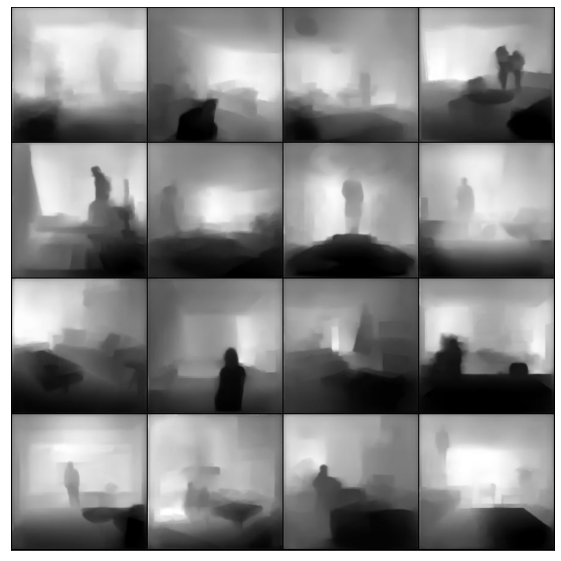

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


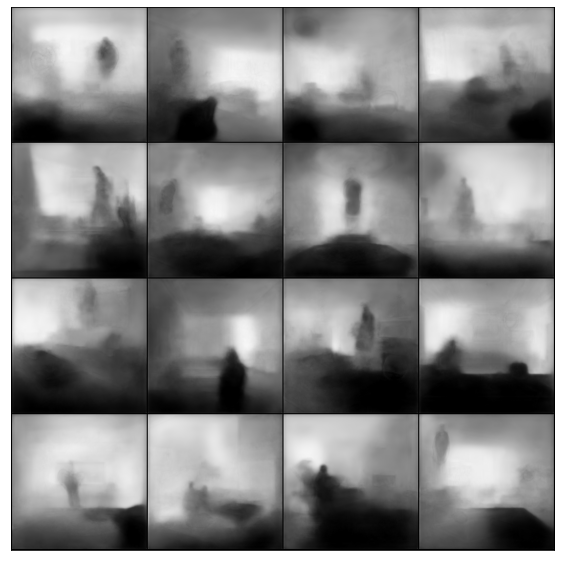

Train Epoch : 4 [40200/280000 (57%)]	Loss: 0.051288
Train Epoch : 4 [40400/280000 (58%)]	Loss: 0.057756
Train Epoch : 4 [40600/280000 (58%)]	Loss: 0.059897
Train Epoch : 4 [40800/280000 (58%)]	Loss: 0.062477
Train Epoch : 4 [41000/280000 (59%)]	Loss: 0.047194
Train Epoch : 4 [41200/280000 (59%)]	Loss: 0.052598
Train Epoch : 4 [41400/280000 (59%)]	Loss: 0.046288
Train Epoch : 4 [41600/280000 (59%)]	Loss: 0.046153
Train Epoch : 4 [41800/280000 (60%)]	Loss: 0.050317
Train Epoch : 4 [42000/280000 (60%)]	Loss: 0.055280
Train Epoch : 4 [42200/280000 (60%)]	Loss: 0.057834
Train Epoch : 4 [42400/280000 (61%)]	Loss: 0.051151
Train Epoch : 4 [42600/280000 (61%)]	Loss: 0.039473
Train Epoch : 4 [42800/280000 (61%)]	Loss: 0.062122
Train Epoch : 4 [43000/280000 (61%)]	Loss: 0.052534
Train Epoch : 4 [43200/280000 (62%)]	Loss: 0.056557
Train Epoch : 4 [43400/280000 (62%)]	Loss: 0.050958
Train Epoch : 4 [43600/280000 (62%)]	Loss: 0.045993
Train Epoch : 4 [43800/280000 (63%)]	Loss: 0.051840
Train Epoch 

RuntimeError: ignored

In [23]:
#Depth epoch4
for epoch in range(4,5):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()
  torch.save(model.state_dict(), '/content/gdrive/My Drive/model_4.pth')

Train Epoch : 1 [0/280000 (0%)]	Loss: 0.028406
Ground Truth


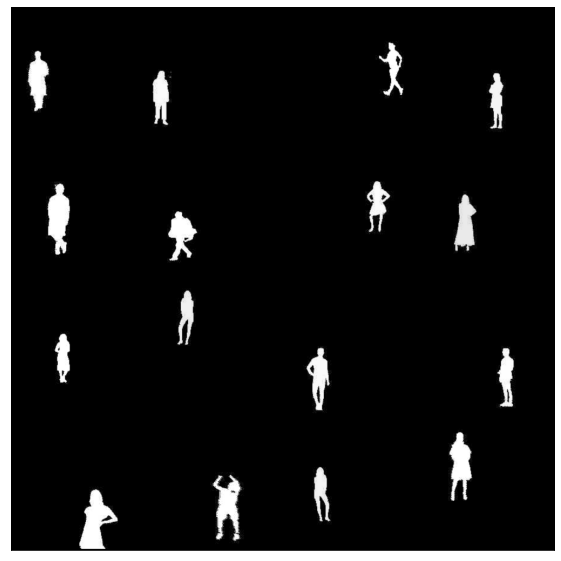

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


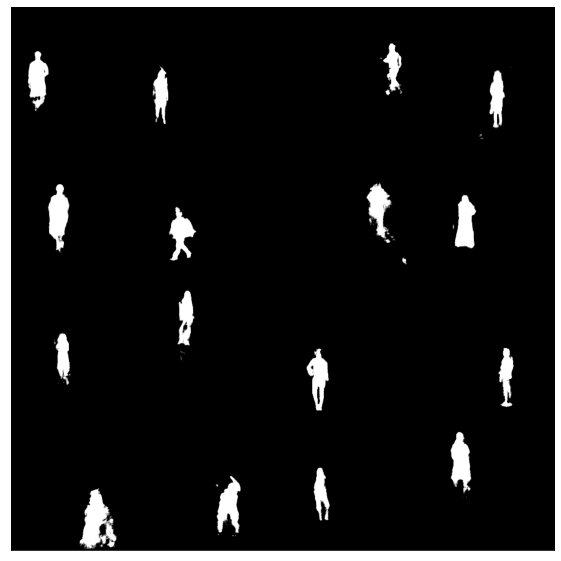

Train Epoch : 1 [200/280000 (0%)]	Loss: 0.038384
Train Epoch : 1 [400/280000 (1%)]	Loss: 0.029508
Train Epoch : 1 [600/280000 (1%)]	Loss: 0.031891
Train Epoch : 1 [800/280000 (1%)]	Loss: 0.038220
Train Epoch : 1 [1000/280000 (1%)]	Loss: 0.029717
Train Epoch : 1 [1200/280000 (2%)]	Loss: 0.027693
Train Epoch : 1 [1400/280000 (2%)]	Loss: 0.026440
Train Epoch : 1 [1600/280000 (2%)]	Loss: 0.028997
Train Epoch : 1 [1800/280000 (3%)]	Loss: 0.034089
Train Epoch : 1 [2000/280000 (3%)]	Loss: 0.033577
Train Epoch : 1 [2200/280000 (3%)]	Loss: 0.028003
Train Epoch : 1 [2400/280000 (3%)]	Loss: 0.030888
Train Epoch : 1 [2600/280000 (4%)]	Loss: 0.025518
Train Epoch : 1 [2800/280000 (4%)]	Loss: 0.026141
Train Epoch : 1 [3000/280000 (4%)]	Loss: 0.027177
Train Epoch : 1 [3200/280000 (5%)]	Loss: 0.027987
Train Epoch : 1 [3400/280000 (5%)]	Loss: 0.031016
Train Epoch : 1 [3600/280000 (5%)]	Loss: 0.025083
Train Epoch : 1 [3800/280000 (5%)]	Loss: 0.036984
Train Epoch : 1 [4000/280000 (6%)]	Loss: 0.028004
Trai

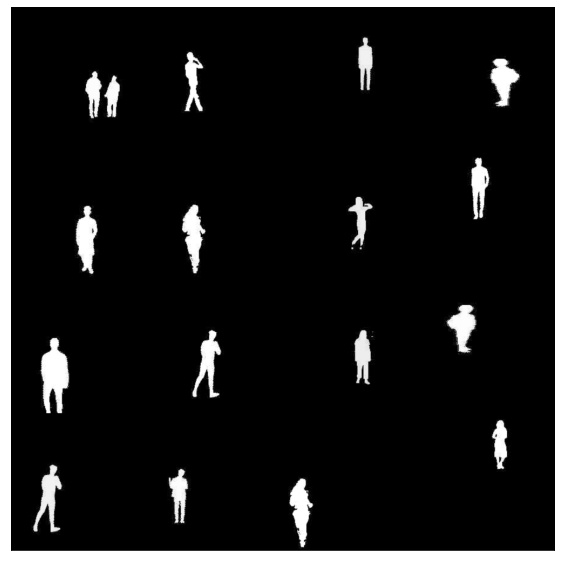

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


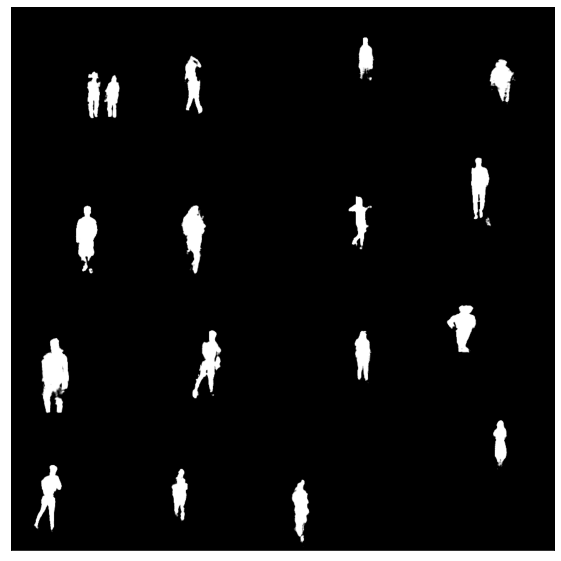

Train Epoch : 1 [20200/280000 (29%)]	Loss: 0.027835
Train Epoch : 1 [20400/280000 (29%)]	Loss: 0.024445
Train Epoch : 1 [20600/280000 (29%)]	Loss: 0.030052
Train Epoch : 1 [20800/280000 (30%)]	Loss: 0.033464
Train Epoch : 1 [21000/280000 (30%)]	Loss: 0.029703
Train Epoch : 1 [21200/280000 (30%)]	Loss: 0.030110
Train Epoch : 1 [21400/280000 (31%)]	Loss: 0.024397
Train Epoch : 1 [21600/280000 (31%)]	Loss: 0.025845
Train Epoch : 1 [21800/280000 (31%)]	Loss: 0.023139
Train Epoch : 1 [22000/280000 (31%)]	Loss: 0.029862
Train Epoch : 1 [22200/280000 (32%)]	Loss: 0.030555
Train Epoch : 1 [22400/280000 (32%)]	Loss: 0.025006
Train Epoch : 1 [22600/280000 (32%)]	Loss: 0.030912
Train Epoch : 1 [22800/280000 (33%)]	Loss: 0.028159
Train Epoch : 1 [23000/280000 (33%)]	Loss: 0.027397
Train Epoch : 1 [23200/280000 (33%)]	Loss: 0.024475
Train Epoch : 1 [23400/280000 (33%)]	Loss: 0.027777
Train Epoch : 1 [23600/280000 (34%)]	Loss: 0.029311
Train Epoch : 1 [23800/280000 (34%)]	Loss: 0.025067
Train Epoch 

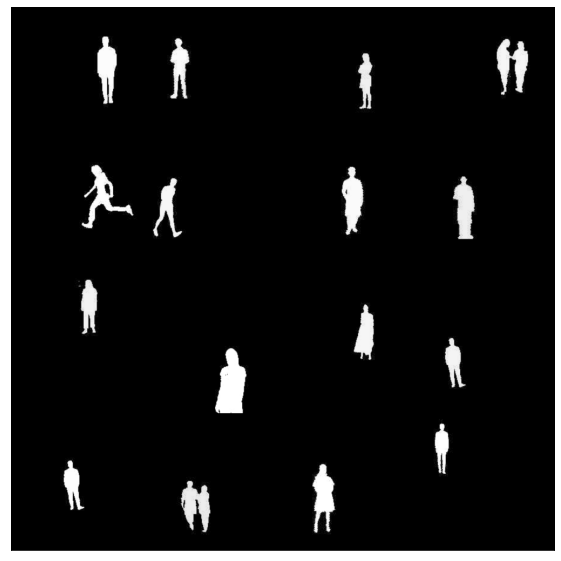

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


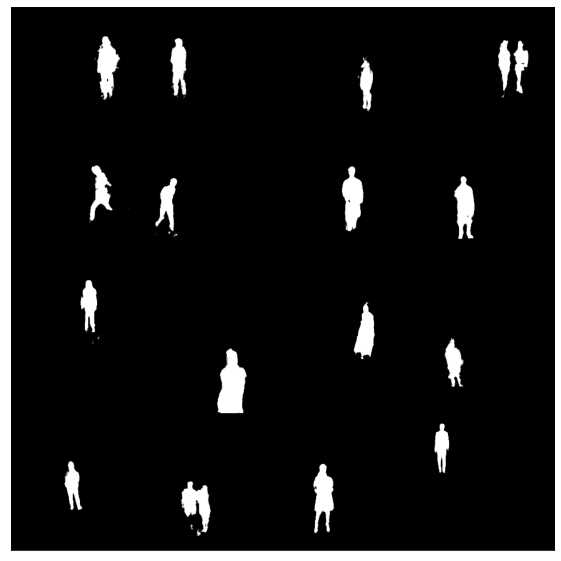

Train Epoch : 1 [40200/280000 (57%)]	Loss: 0.021414
Train Epoch : 1 [40400/280000 (58%)]	Loss: 0.022164
Train Epoch : 1 [40600/280000 (58%)]	Loss: 0.028865
Train Epoch : 1 [40800/280000 (58%)]	Loss: 0.026656
Train Epoch : 1 [41000/280000 (59%)]	Loss: 0.030505
Train Epoch : 1 [41200/280000 (59%)]	Loss: 0.028491
Train Epoch : 1 [41400/280000 (59%)]	Loss: 0.023590
Train Epoch : 1 [41600/280000 (59%)]	Loss: 0.026587
Train Epoch : 1 [41800/280000 (60%)]	Loss: 0.035525
Train Epoch : 1 [42000/280000 (60%)]	Loss: 0.025672
Train Epoch : 1 [42200/280000 (60%)]	Loss: 0.022755
Train Epoch : 1 [42400/280000 (61%)]	Loss: 0.024900
Train Epoch : 1 [42600/280000 (61%)]	Loss: 0.024409
Train Epoch : 1 [42800/280000 (61%)]	Loss: 0.028066
Train Epoch : 1 [43000/280000 (61%)]	Loss: 0.029713
Train Epoch : 1 [43200/280000 (62%)]	Loss: 0.024187
Train Epoch : 1 [43400/280000 (62%)]	Loss: 0.026312
Train Epoch : 1 [43600/280000 (62%)]	Loss: 0.024210
Train Epoch : 1 [43800/280000 (63%)]	Loss: 0.030320
Train Epoch 

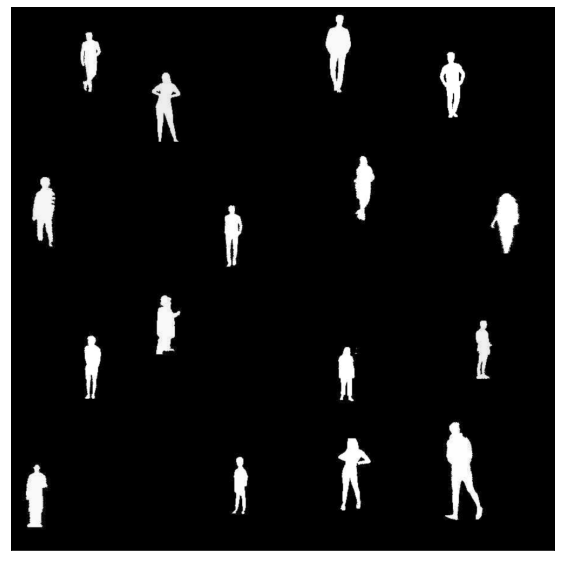

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


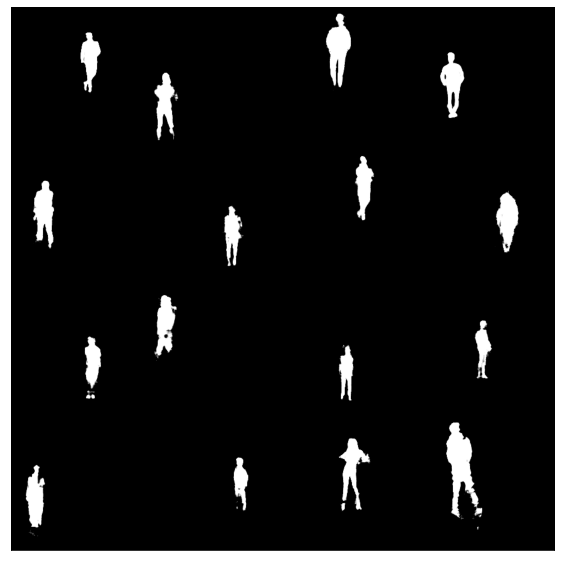

Train Epoch : 1 [60200/280000 (86%)]	Loss: 0.024872
Train Epoch : 1 [60400/280000 (86%)]	Loss: 0.030078
Train Epoch : 1 [60600/280000 (87%)]	Loss: 0.028481
Train Epoch : 1 [60800/280000 (87%)]	Loss: 0.030297
Train Epoch : 1 [61000/280000 (87%)]	Loss: 0.025837
Train Epoch : 1 [61200/280000 (87%)]	Loss: 0.027573
Train Epoch : 1 [61400/280000 (88%)]	Loss: 0.031139
Train Epoch : 1 [61600/280000 (88%)]	Loss: 0.026169
Train Epoch : 1 [61800/280000 (88%)]	Loss: 0.021590
Train Epoch : 1 [62000/280000 (89%)]	Loss: 0.021935
Train Epoch : 1 [62200/280000 (89%)]	Loss: 0.023804
Train Epoch : 1 [62400/280000 (89%)]	Loss: 0.024372
Train Epoch : 1 [62600/280000 (89%)]	Loss: 0.026731
Train Epoch : 1 [62800/280000 (90%)]	Loss: 0.025005
Train Epoch : 1 [63000/280000 (90%)]	Loss: 0.025779
Train Epoch : 1 [63200/280000 (90%)]	Loss: 0.024227
Train Epoch : 1 [63400/280000 (91%)]	Loss: 0.019556
Train Epoch : 1 [63600/280000 (91%)]	Loss: 0.026306
Train Epoch : 1 [63800/280000 (91%)]	Loss: 0.025620
Train Epoch 

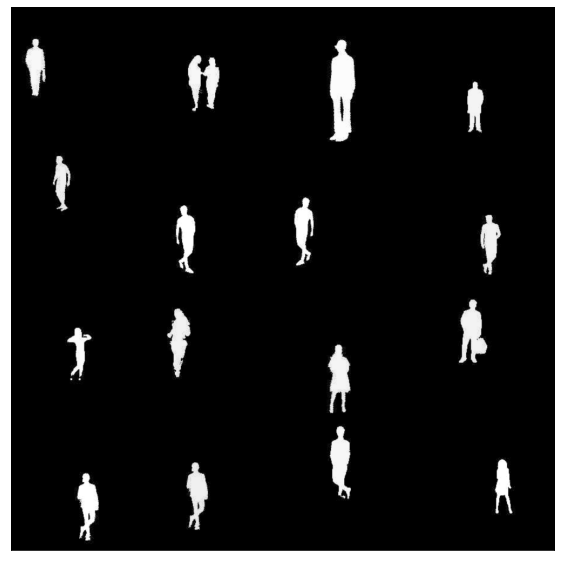

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


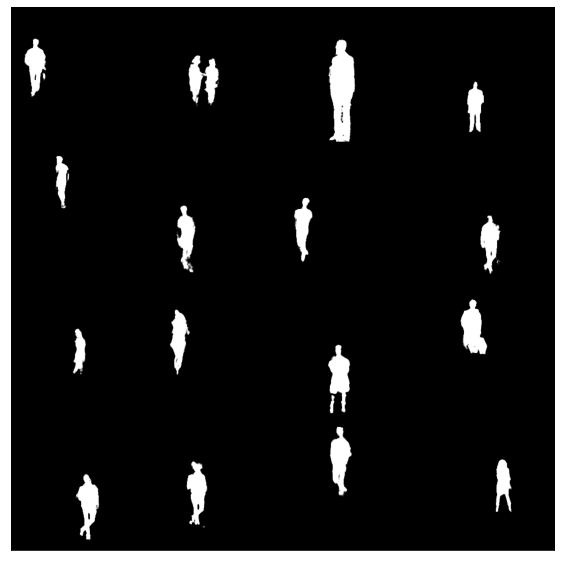

In [20]:
#Mask epoch 1
for epoch in range(1,2):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()
  torch.save(model.state_dict(), '/content/gdrive/My Drive/mask_2.pth')

Train Epoch : 2 [0/280000 (0%)]	Loss: 0.021426
Ground Truth


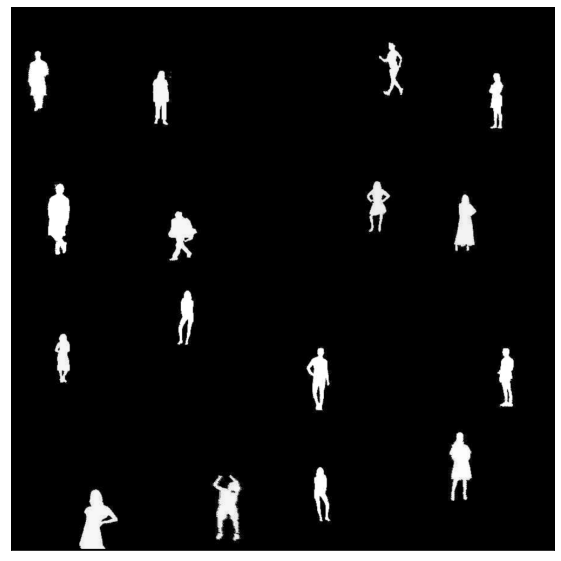

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


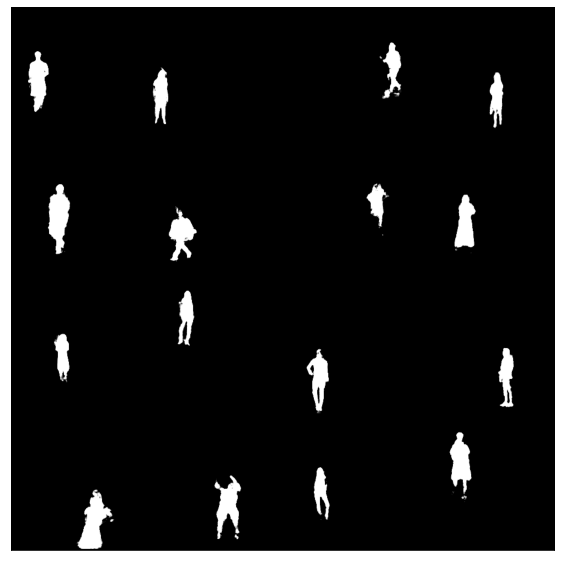

Train Epoch : 2 [200/280000 (0%)]	Loss: 0.030039
Train Epoch : 2 [400/280000 (1%)]	Loss: 0.022733
Train Epoch : 2 [600/280000 (1%)]	Loss: 0.026181
Train Epoch : 2 [800/280000 (1%)]	Loss: 0.032612
Train Epoch : 2 [1000/280000 (1%)]	Loss: 0.023935
Train Epoch : 2 [1200/280000 (2%)]	Loss: 0.021750
Train Epoch : 2 [1400/280000 (2%)]	Loss: 0.023048
Train Epoch : 2 [1600/280000 (2%)]	Loss: 0.023874
Train Epoch : 2 [1800/280000 (3%)]	Loss: 0.027934
Train Epoch : 2 [2000/280000 (3%)]	Loss: 0.024911
Train Epoch : 2 [2200/280000 (3%)]	Loss: 0.027016
Train Epoch : 2 [2400/280000 (3%)]	Loss: 0.025054
Train Epoch : 2 [2600/280000 (4%)]	Loss: 0.020462
Train Epoch : 2 [2800/280000 (4%)]	Loss: 0.022954
Train Epoch : 2 [3000/280000 (4%)]	Loss: 0.024560
Train Epoch : 2 [3200/280000 (5%)]	Loss: 0.022390
Train Epoch : 2 [3400/280000 (5%)]	Loss: 0.025935
Train Epoch : 2 [3600/280000 (5%)]	Loss: 0.022197
Train Epoch : 2 [3800/280000 (5%)]	Loss: 0.030719
Train Epoch : 2 [4000/280000 (6%)]	Loss: 0.025614
Trai

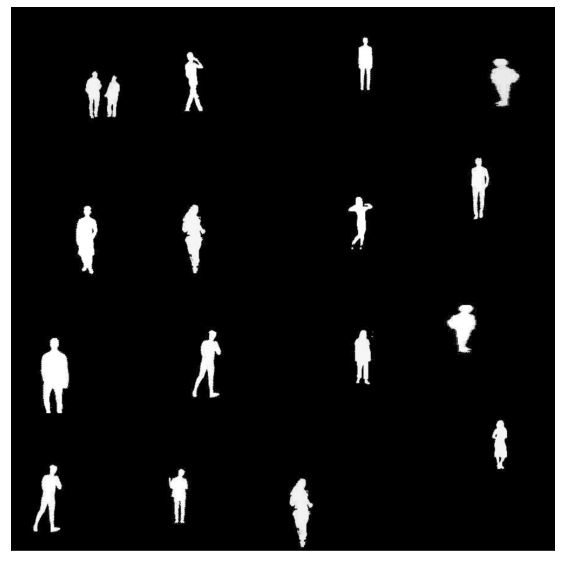

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


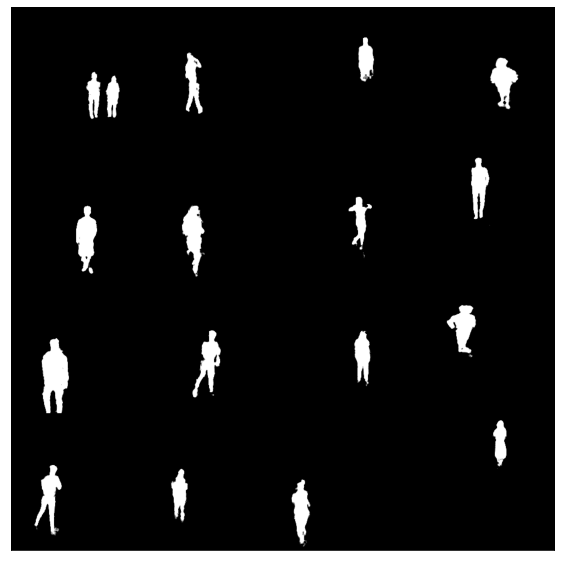

Train Epoch : 2 [20200/280000 (29%)]	Loss: 0.026072
Train Epoch : 2 [20400/280000 (29%)]	Loss: 0.023267
Train Epoch : 2 [20600/280000 (29%)]	Loss: 0.024581
Train Epoch : 2 [20800/280000 (30%)]	Loss: 0.025691
Train Epoch : 2 [21000/280000 (30%)]	Loss: 0.025025
Train Epoch : 2 [21200/280000 (30%)]	Loss: 0.024272
Train Epoch : 2 [21400/280000 (31%)]	Loss: 0.022171
Train Epoch : 2 [21600/280000 (31%)]	Loss: 0.023365
Train Epoch : 2 [21800/280000 (31%)]	Loss: 0.018926
Train Epoch : 2 [22000/280000 (31%)]	Loss: 0.025002
Train Epoch : 2 [22200/280000 (32%)]	Loss: 0.027579
Train Epoch : 2 [22400/280000 (32%)]	Loss: 0.022732
Train Epoch : 2 [22600/280000 (32%)]	Loss: 0.030611
Train Epoch : 2 [22800/280000 (33%)]	Loss: 0.024942
Train Epoch : 2 [23000/280000 (33%)]	Loss: 0.022699
Train Epoch : 2 [23200/280000 (33%)]	Loss: 0.020153
Train Epoch : 2 [23400/280000 (33%)]	Loss: 0.024015
Train Epoch : 2 [23600/280000 (34%)]	Loss: 0.025534
Train Epoch : 2 [23800/280000 (34%)]	Loss: 0.022877
Train Epoch 

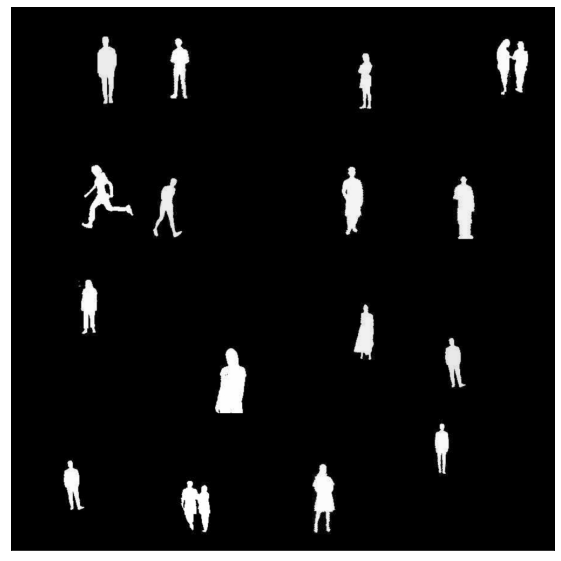

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


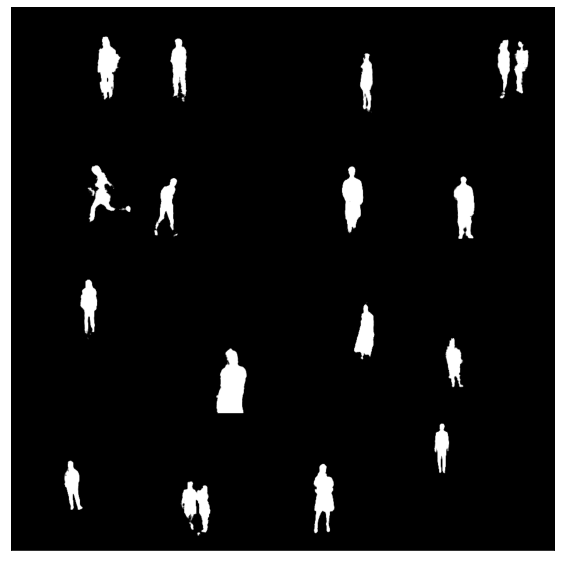

Train Epoch : 2 [40200/280000 (57%)]	Loss: 0.020593
Train Epoch : 2 [40400/280000 (58%)]	Loss: 0.020966
Train Epoch : 2 [40600/280000 (58%)]	Loss: 0.024240
Train Epoch : 2 [40800/280000 (58%)]	Loss: 0.022271
Train Epoch : 2 [41000/280000 (59%)]	Loss: 0.024982
Train Epoch : 2 [41200/280000 (59%)]	Loss: 0.026413
Train Epoch : 2 [41400/280000 (59%)]	Loss: 0.021282
Train Epoch : 2 [41600/280000 (59%)]	Loss: 0.022820
Train Epoch : 2 [41800/280000 (60%)]	Loss: 0.029303
Train Epoch : 2 [42000/280000 (60%)]	Loss: 0.021543
Train Epoch : 2 [42200/280000 (60%)]	Loss: 0.018813
Train Epoch : 2 [42400/280000 (61%)]	Loss: 0.022133
Train Epoch : 2 [42600/280000 (61%)]	Loss: 0.023117
Train Epoch : 2 [42800/280000 (61%)]	Loss: 0.024369
Train Epoch : 2 [43000/280000 (61%)]	Loss: 0.025212
Train Epoch : 2 [43200/280000 (62%)]	Loss: 0.020010
Train Epoch : 2 [43400/280000 (62%)]	Loss: 0.026123
Train Epoch : 2 [43600/280000 (62%)]	Loss: 0.023380
Train Epoch : 2 [43800/280000 (63%)]	Loss: 0.028283
Train Epoch 

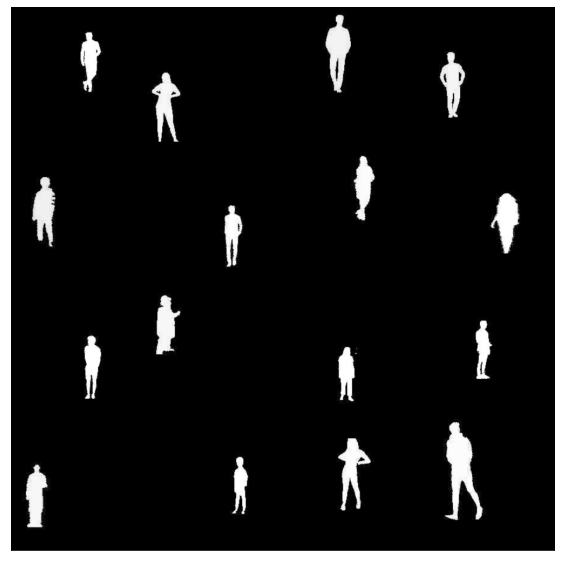

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


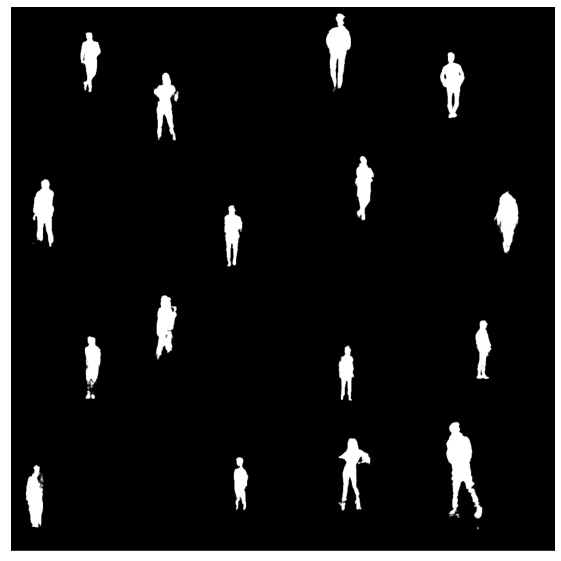

Train Epoch : 2 [60200/280000 (86%)]	Loss: 0.021847
Train Epoch : 2 [60400/280000 (86%)]	Loss: 0.024333
Train Epoch : 2 [60600/280000 (87%)]	Loss: 0.021788
Train Epoch : 2 [60800/280000 (87%)]	Loss: 0.022841
Train Epoch : 2 [61000/280000 (87%)]	Loss: 0.020240
Train Epoch : 2 [61200/280000 (87%)]	Loss: 0.022012
Train Epoch : 2 [61400/280000 (88%)]	Loss: 0.025861
Train Epoch : 2 [61600/280000 (88%)]	Loss: 0.024129
Train Epoch : 2 [61800/280000 (88%)]	Loss: 0.021619
Train Epoch : 2 [62000/280000 (89%)]	Loss: 0.020385
Train Epoch : 2 [62200/280000 (89%)]	Loss: 0.022261
Train Epoch : 2 [62400/280000 (89%)]	Loss: 0.020463
Train Epoch : 2 [62600/280000 (89%)]	Loss: 0.024484
Train Epoch : 2 [62800/280000 (90%)]	Loss: 0.022034
Train Epoch : 2 [63000/280000 (90%)]	Loss: 0.024260
Train Epoch : 2 [63200/280000 (90%)]	Loss: 0.022169
Train Epoch : 2 [63400/280000 (91%)]	Loss: 0.019304
Train Epoch : 2 [63600/280000 (91%)]	Loss: 0.023010
Train Epoch : 2 [63800/280000 (91%)]	Loss: 0.023654
Train Epoch 

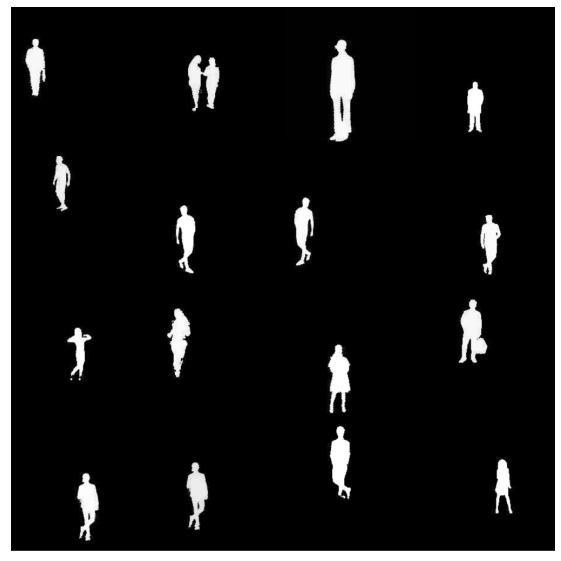

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


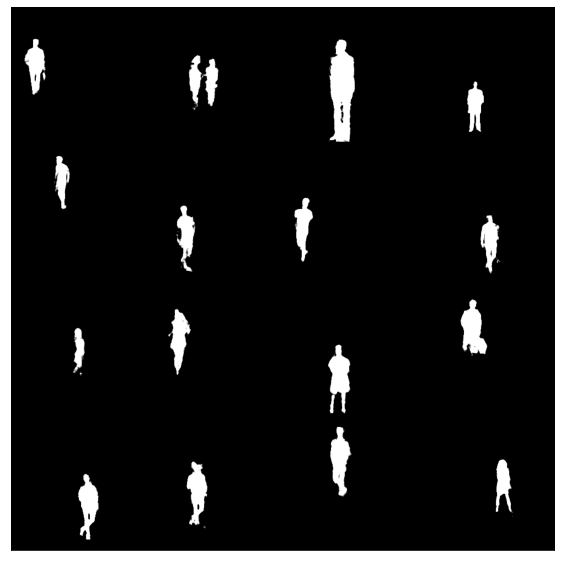

In [26]:
#Mask epoch 2
for epoch in range(2,3):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()
  torch.save(model.state_dict(), '/content/gdrive/My Drive/mask_3.pth')

Train Epoch : 3 [0/280000 (0%)]	Loss: 0.020523
Ground Truth


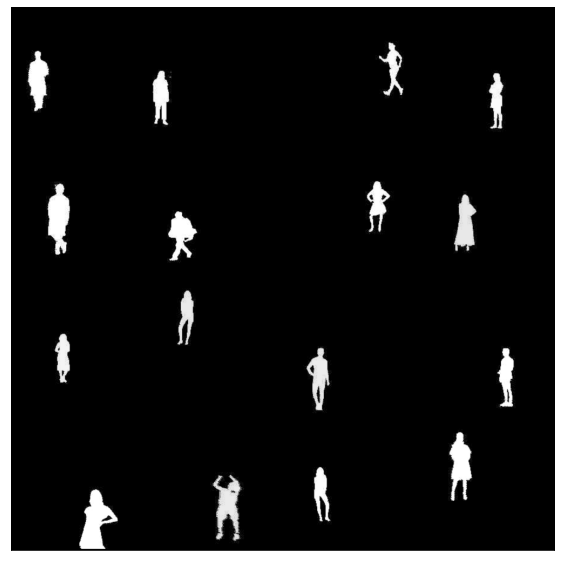

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


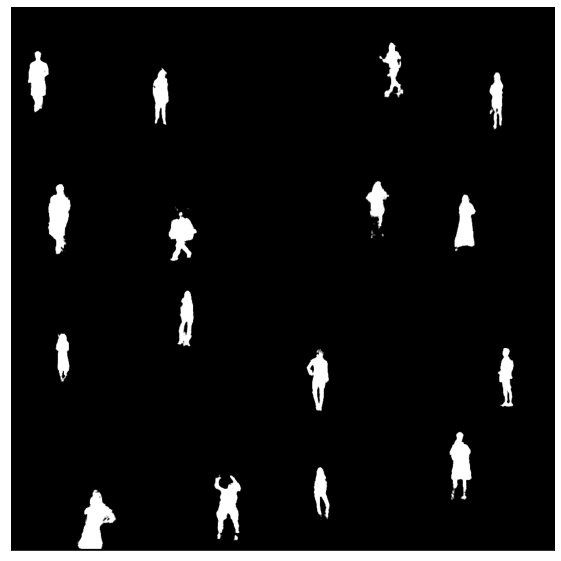

Train Epoch : 3 [200/280000 (0%)]	Loss: 0.028833
Train Epoch : 3 [400/280000 (1%)]	Loss: 0.020744
Train Epoch : 3 [600/280000 (1%)]	Loss: 0.024342
Train Epoch : 3 [800/280000 (1%)]	Loss: 0.025217
Train Epoch : 3 [1000/280000 (1%)]	Loss: 0.019391
Train Epoch : 3 [1200/280000 (2%)]	Loss: 0.019180
Train Epoch : 3 [1400/280000 (2%)]	Loss: 0.020523
Train Epoch : 3 [1600/280000 (2%)]	Loss: 0.021146
Train Epoch : 3 [1800/280000 (3%)]	Loss: 0.026753
Train Epoch : 3 [2000/280000 (3%)]	Loss: 0.023664
Train Epoch : 3 [2200/280000 (3%)]	Loss: 0.022798
Train Epoch : 3 [2400/280000 (3%)]	Loss: 0.024116
Train Epoch : 3 [2600/280000 (4%)]	Loss: 0.019159
Train Epoch : 3 [2800/280000 (4%)]	Loss: 0.018529
Train Epoch : 3 [3000/280000 (4%)]	Loss: 0.025403
Train Epoch : 3 [3200/280000 (5%)]	Loss: 0.019953
Train Epoch : 3 [3400/280000 (5%)]	Loss: 0.025112
Train Epoch : 3 [3600/280000 (5%)]	Loss: 0.020531
Train Epoch : 3 [3800/280000 (5%)]	Loss: 0.026905
Train Epoch : 3 [4000/280000 (6%)]	Loss: 0.021522
Trai

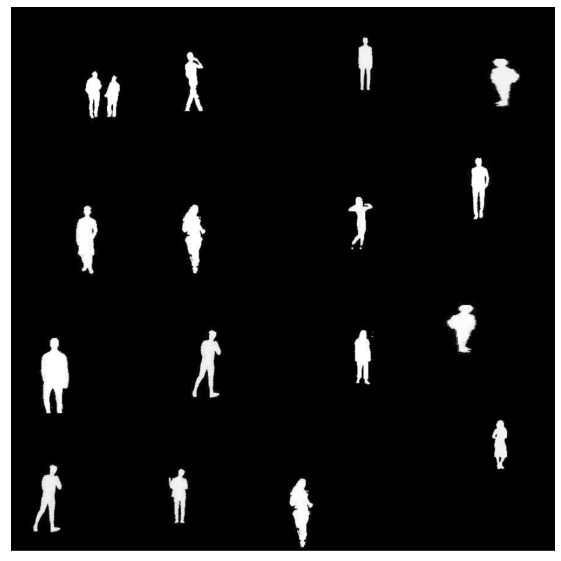

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


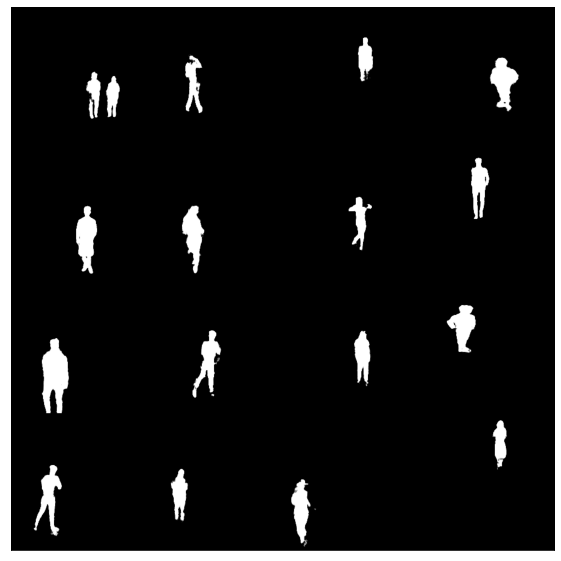

Train Epoch : 3 [20200/280000 (29%)]	Loss: 0.021499
Train Epoch : 3 [20400/280000 (29%)]	Loss: 0.020771
Train Epoch : 3 [20600/280000 (29%)]	Loss: 0.024035
Train Epoch : 3 [20800/280000 (30%)]	Loss: 0.023588
Train Epoch : 3 [21000/280000 (30%)]	Loss: 0.023084
Train Epoch : 3 [21200/280000 (30%)]	Loss: 0.023027
Train Epoch : 3 [21400/280000 (31%)]	Loss: 0.020165
Train Epoch : 3 [21600/280000 (31%)]	Loss: 0.021162
Train Epoch : 3 [21800/280000 (31%)]	Loss: 0.018158
Train Epoch : 3 [22000/280000 (31%)]	Loss: 0.023032
Train Epoch : 3 [22200/280000 (32%)]	Loss: 0.023642
Train Epoch : 3 [22400/280000 (32%)]	Loss: 0.020240
Train Epoch : 3 [22600/280000 (32%)]	Loss: 0.025926
Train Epoch : 3 [22800/280000 (33%)]	Loss: 0.021984
Train Epoch : 3 [23000/280000 (33%)]	Loss: 0.022631
Train Epoch : 3 [23200/280000 (33%)]	Loss: 0.018377
Train Epoch : 3 [23400/280000 (33%)]	Loss: 0.024510
Train Epoch : 3 [23600/280000 (34%)]	Loss: 0.023722
Train Epoch : 3 [23800/280000 (34%)]	Loss: 0.019756
Train Epoch 

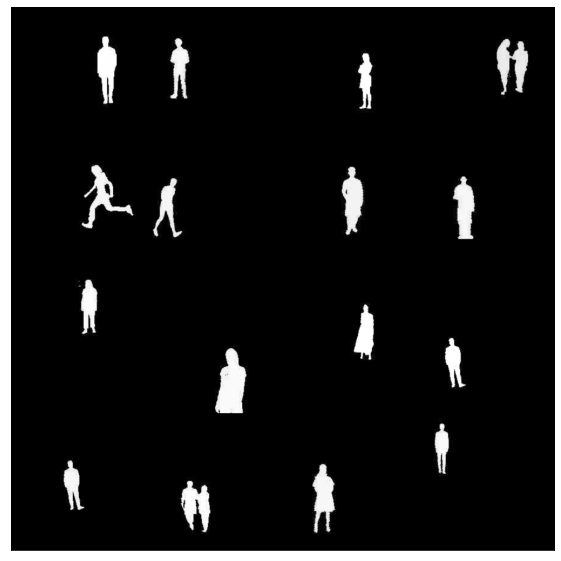

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training


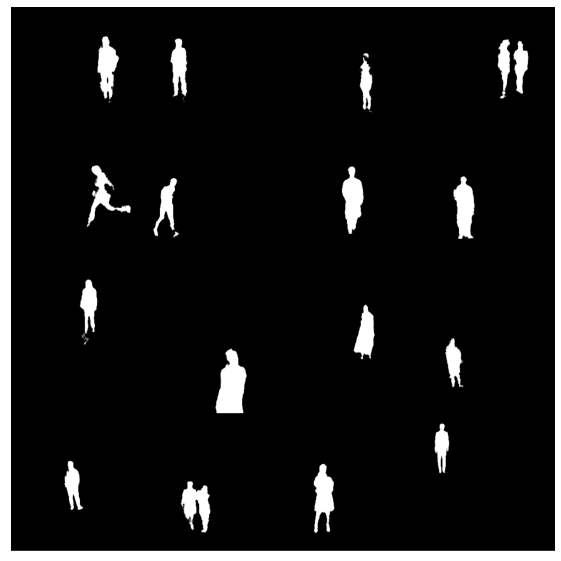

Train Epoch : 3 [40200/280000 (57%)]	Loss: 0.018897
Train Epoch : 3 [40400/280000 (58%)]	Loss: 0.019871
Train Epoch : 3 [40600/280000 (58%)]	Loss: 0.022382
Train Epoch : 3 [40800/280000 (58%)]	Loss: 0.024815
Train Epoch : 3 [41000/280000 (59%)]	Loss: 0.021343
Train Epoch : 3 [41200/280000 (59%)]	Loss: 0.022870
Train Epoch : 3 [41400/280000 (59%)]	Loss: 0.020426
Train Epoch : 3 [41600/280000 (59%)]	Loss: 0.019555
Train Epoch : 3 [41800/280000 (60%)]	Loss: 0.028484
Train Epoch : 3 [42000/280000 (60%)]	Loss: 0.021467
Train Epoch : 3 [42200/280000 (60%)]	Loss: 0.020247
Train Epoch : 3 [42400/280000 (61%)]	Loss: 0.021381
Train Epoch : 3 [42600/280000 (61%)]	Loss: 0.023777
Train Epoch : 3 [42800/280000 (61%)]	Loss: 0.022220
Train Epoch : 3 [43000/280000 (61%)]	Loss: 0.025604
Train Epoch : 3 [43200/280000 (62%)]	Loss: 0.018389
Train Epoch : 3 [43400/280000 (62%)]	Loss: 0.021576
Train Epoch : 3 [43600/280000 (62%)]	Loss: 0.020845
Train Epoch : 3 [43800/280000 (63%)]	Loss: 0.027098
Train Epoch 

In [0]:
#Mask epoch 3
for epoch in range(3,4):
  train(model, criterion,device, train_dataloader, optim, epoch)
  print("------------------------------------------------")
  test(model, criterion, device, test_dataloader)
  scheduler.step()
  torch.save(model.state_dict(), '/content/gdrive/My Drive/mask_4.pth')

**RMSE**

In [0]:
metric = RMSE()

Average Metric =  0.6715668320655823
Ground Truth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


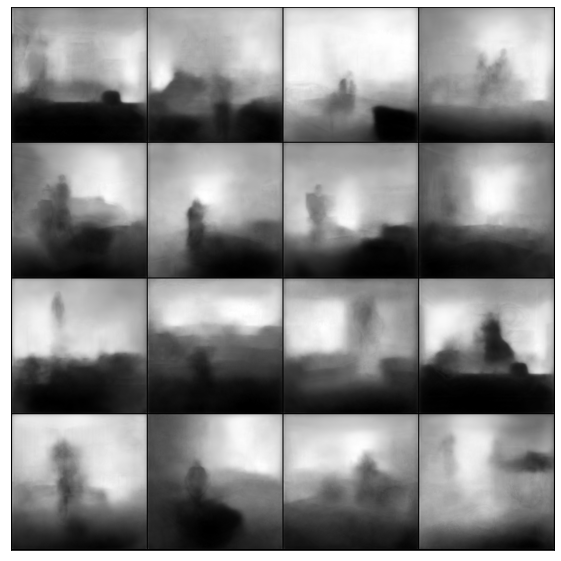

In [59]:
test(model, criterion, device, test_dataloader, metric)

**Measure IoU for accuracy**

In [0]:
metric = smp.utils.metrics.IoU(threshold=0.5)

Average Metric =  0.8109732806682587
Ground Truth


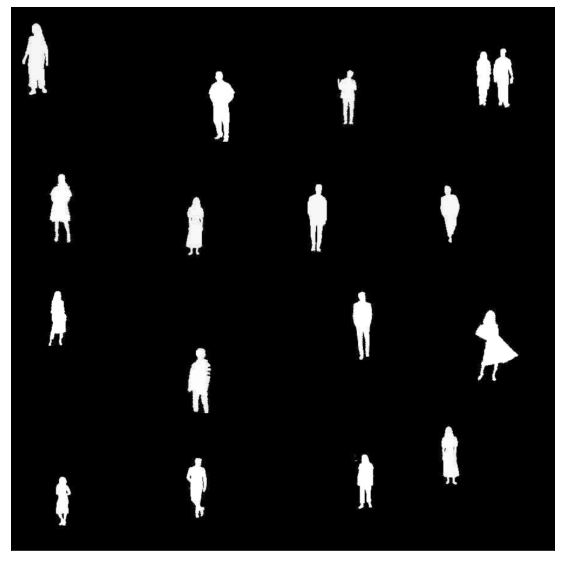

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Testing


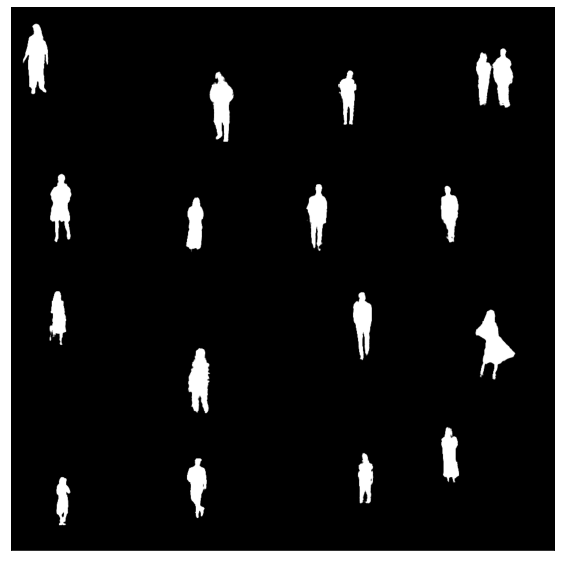

In [46]:
test(model, criterion, device, test_dataloader, metric)

**Loading weights after each epoch**

In [53]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/mask_3.pth'))

<All keys matched successfully>